# Euromillion scraper 

By using web scraping, the aime of the project is to get every euromillion results to do statistic over it.
To do so, we will use **selenium** package. 

```
pip install selenium
pip install pandas
pip install seaborn
pip install matplotlib
```

## Scraping

### Imports

In [1]:
from selenium.webdriver import Firefox
from selenium.webdriver.firefox.options import Options

First we will get every page urls 
To do so, on the landing page and we get every href value of **a** tags, which contains a link to the draw history of a year

In [2]:
url = "https://www.tirage-euromillions.net/euromillions/annees/"
options = Options()

# to hide the browser 
options.headless = True

browser = Firefox(options=options)
browser.get(url)

# get every tag 'a' in the 'li' tag
draws = browser.find_elements_by_xpath("//*[contains(@href, 'annee-20')]")

page_urls = []
for draw in draws:
    
    href = draw.get_attribute("href")
    
    page_urls.append(href)

#page_urls

In [3]:
def extract_text_as_numb(elements: list) -> list:
    """
        get a list of int out of a list of HTML DOM
    """
    
    texts = []
    for el in elements:
        texts.append(int(el.text))
    return texts

def scrap_numbers(browser) -> list:
    """
        get a list of dict from a browser
    """
    
    css_selector = "tr"
    rows = browser.find_elements_by_tag_name(css_selector)
    
    trs = []
    for row in rows:
        try:
            # if the element doesn't contain a double td then drop this row
            # otherwise save it
            row.find_element_by_css_selector("td+td")
            trs.append(row)
        except:
            continue
    
    results = []
    for tr in trs:
        tds = tr.find_elements_by_tag_name("td")
        date = tds[0].text
        
        game_points = tr.find_elements_by_class_name("game_point")
        
        stars = tr.find_elements_by_class_name("star_small")
        
        line = {
            "date": date, 
            "numbers": extract_text_as_numb(game_points), 
            "stars": extract_text_as_numb(stars)
        }
        
        results.append(line)
    
    return results

Foreach page url scrap the content and add it to the record. 

This action might take some times because scraping process is timeconsuming

In [4]:
browser = Firefox(options=options)
euro_millions = []

for page_url in page_urls:
    browser.get(page_url)
    euro_millions += scrap_numbers(browser)
    
euro_millions[0:5]

[{'date': 'Vendredi 16/04/2021',
  'numbers': [6, 11, 29, 40, 48],
  'stars': [5, 9]},
 {'date': 'Mardi 13/04/2021',
  'numbers': [16, 20, 31, 47, 50],
  'stars': [2, 8]},
 {'date': 'Vendredi 09/04/2021',
  'numbers': [2, 8, 32, 35, 44],
  'stars': [8, 11]},
 {'date': 'Mardi 06/04/2021', 'numbers': [2, 21, 37, 38, 50], 'stars': [7, 8]},
 {'date': 'Vendredi 02/04/2021',
  'numbers': [4, 21, 34, 40, 47],
  'stars': [2, 5]}]

Save the results as a csv file and we will be ready to work on our dataset.

In [5]:
import csv
keys = euro_millions[0].keys()
with open('euro_million_history.csv', 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(euro_millions)

## Analysis

Using the dataset we just created, we are going to see if there are a miracle draw or a combinaison of numbers which often appears. 

Few questions in mind according to all of this. the question that all players ask themselves:
* **Is this game balanced ?**
* **Can we increase our chances of winning ?**

### imports

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme(style="whitegrid")

In [7]:
df = pd.read_csv("euro_million_history.csv")
df.head()

,date,numbers,stars
0,Vendredi 16/04/2021,"[6, 11, 29, 40, 48]","[5, 9]"
1,Mardi 13/04/2021,"[16, 20, 31, 47, 50]","[2, 8]"
2,Vendredi 09/04/2021,"[2, 8, 32, 35, 44]","[8, 11]"
3,Mardi 06/04/2021,"[2, 21, 37, 38, 50]","[7, 8]"
4,Vendredi 02/04/2021,"[4, 21, 34, 40, 47]","[2, 5]"


In [8]:
df.describe()

,date,numbers,stars
count,1416,1416,1416
unique,1416,1416,124
top,Vendredi 14/11/2014,"[30, 26, 48, 15, 8]","[2, 6]"
freq,1,1,25


In [9]:
def prepare_numbers(dataframe, col_name:str) -> np.array:
    arr = np.array(dataframe[col_name].array)
    
    def cb(arg):
        res = arg.replace('[', '').replace(']', '').replace(',','')
        return np.array(res.split(' ')).astype(int)
    
    return np.array(list(map(cb, arr))).flatten()
          

In [10]:
numbers = prepare_numbers(df, "numbers")
stars = prepare_numbers(df, "stars")

stars

array([5, 9, 2, ..., 5, 6, 5])

[Text(0, 0.5, 'Nb of occurence'), Text(0.5, 1.0, 'Number histogram')]

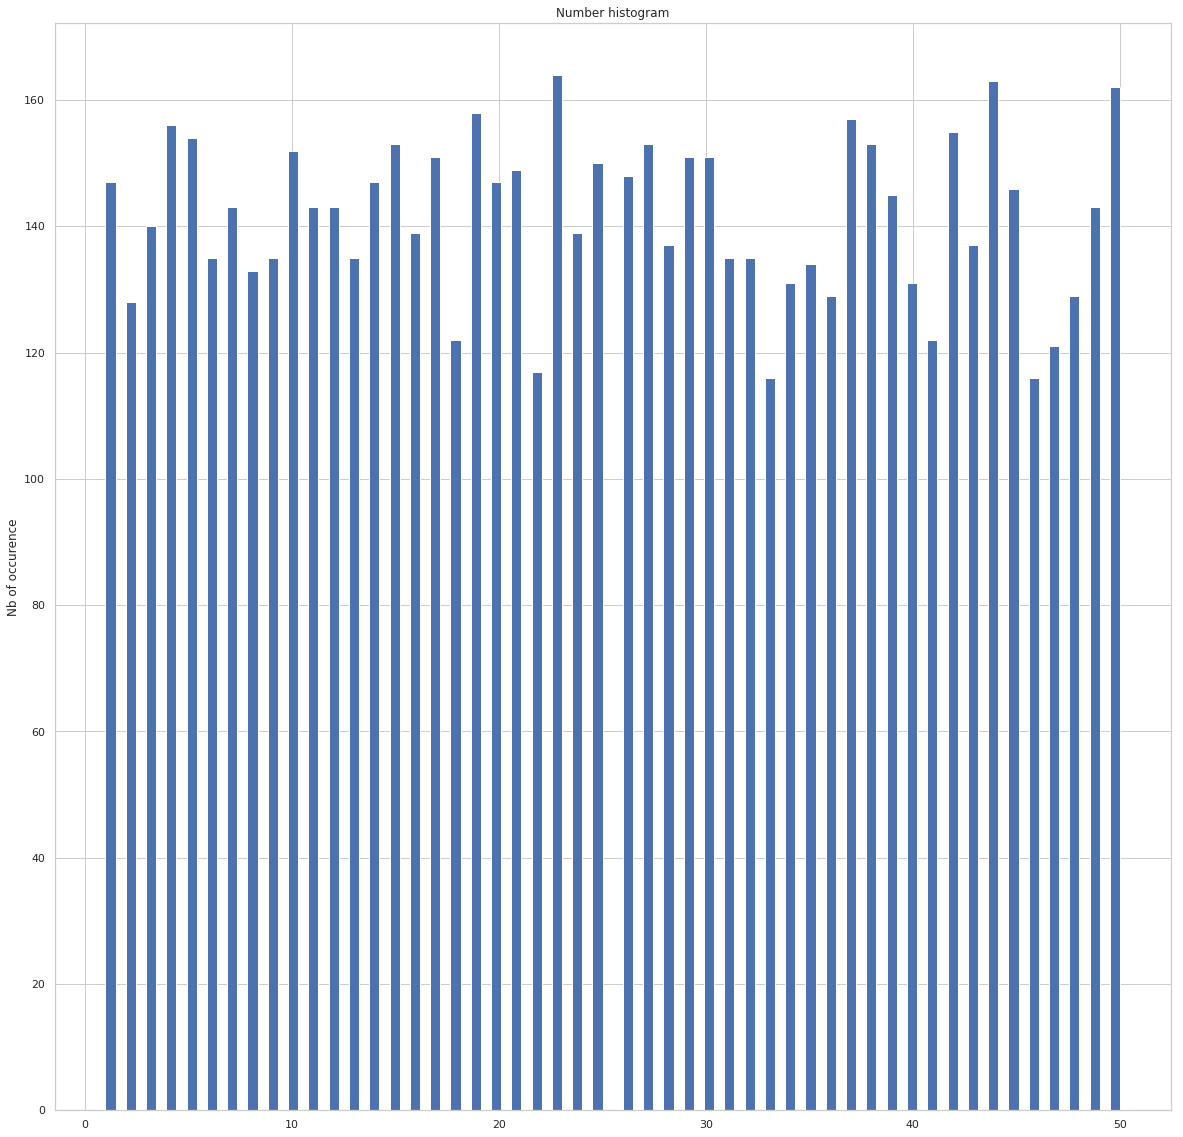

In [11]:
plt.figure(figsize=(20,20))
plt.hist(numbers, bins=100)
plt.gca().set(title='Number histogram', ylabel='Nb of occurence')


In [12]:
(unique, counts) = np.unique(numbers, return_counts=True)
occurence = np.asarray((unique, counts)).T
np.sort(occurence, axis=1)

# sort by number of occurence
sorted_occurence = sorted(occurence, key=lambda row: row[1])

count = df.shape[0]

df_numbers = pd.DataFrame((list(map(lambda x: {"number": x[0], "frequencies": (x[1]/count) * 100} ,sorted_occurence))))
df_numbers.tail(5)

,frequencies,number
45,11.087571,37
46,11.158192,19
47,11.440678,50
48,11.511299,44
49,11.581921,23


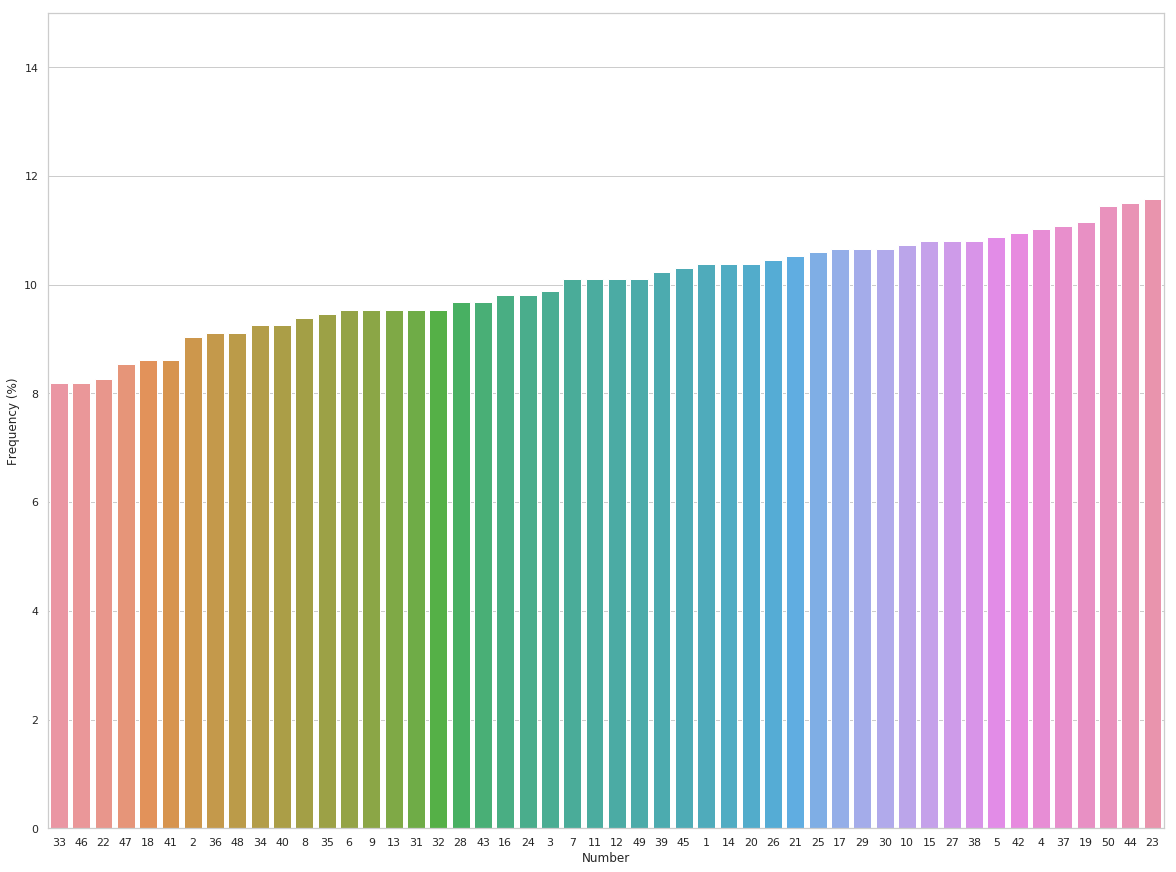

In [13]:
plt.figure(figsize=(20,15))
ax = sns.barplot(data=df_numbers, x="number", y="frequencies", order=df_numbers["number"], estimator=np.median)
ax.set(xlabel='Number', ylabel='Frequency (%)')
ax.set_ylim([0,15])
plt.show()

The chart above show us that with almost 1500 lines, the distribution of the frequencies is close to uniform. Each numbers has a frequency greater than 8% and lower than 12%

Even if some numbers appear more often than the other ones, the difference isn't significative enough to get a trend. So unfortunetly, it seems that there isn't a magic trick.

Yet, to go further we can pick a random number a see which of the other numbers are more likely to get you a win (according to the winning combinaisons)

In [14]:
(unique, counts) = np.unique(stars, return_counts=True)
frequencies = np.asarray((unique, counts)).T
np.sort(frequencies, axis=1)
sorted_frequencies = sorted(frequencies, key=lambda row: row[1])

df_stars = pd.DataFrame(
    list(
        map(lambda x: {"number": x[0], "count": x[1]} ,sorted_frequencies)
    )
)

df_stars.tail(5)

,count,number
7,260,5
8,266,9
9,283,3
10,285,8
11,289,2


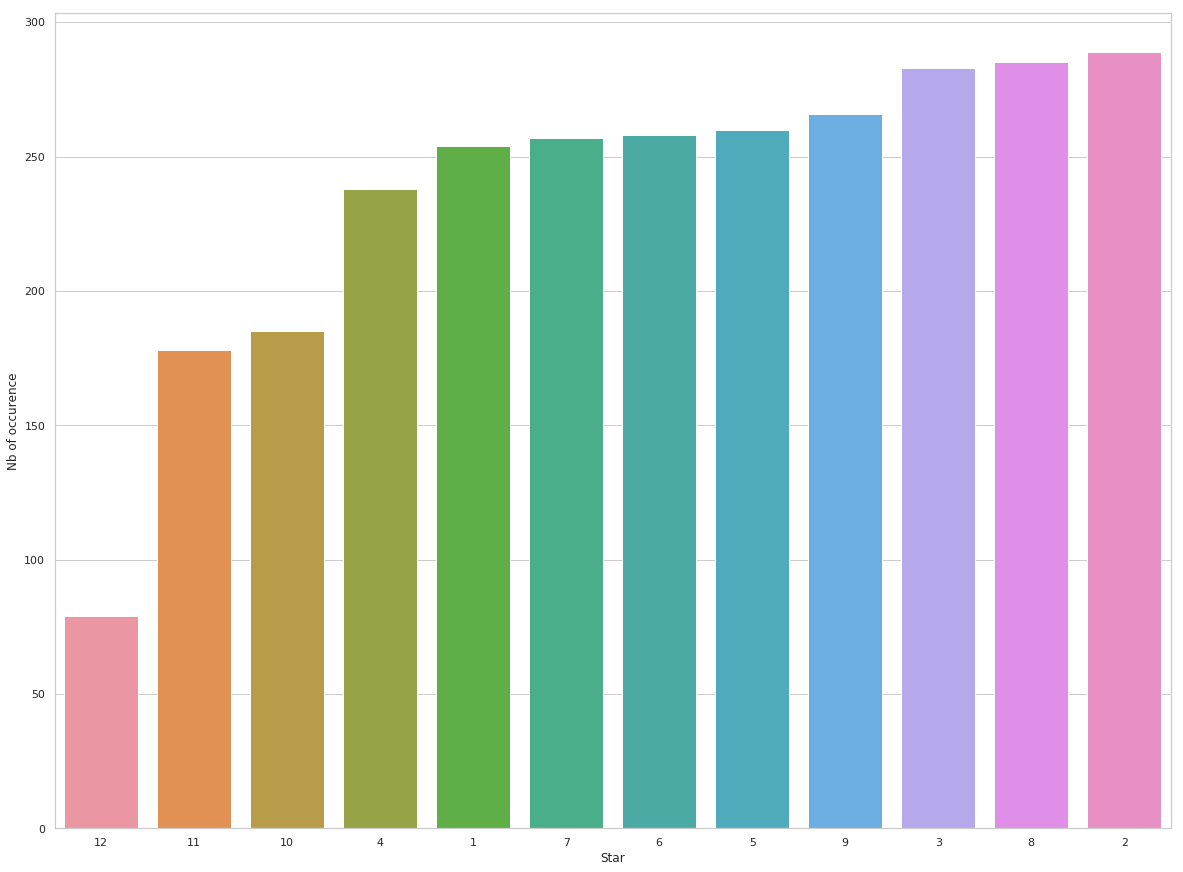

In [15]:
plt.figure(figsize=(20,15))
ax = sns.barplot(data=df_stars, x="number", y="count", order=df_stars["number"], estimator=np.median)
ax.set(xlabel='Star', ylabel='Nb of occurence')
plt.show()

Contrary to the histogram of the numbers, we can see here a more significative difference in the number of apparence. The star eleven doesn't appear a lot. So if you follow the trend, we shouldn't bet on the 12 nor 11 or 10 stars if we want to maximise our chance to win